In [77]:
import os
import sys
import pandas as pd
import pickle
import numpy as np
from scipy.linalg import toeplitz
import scanpy as sc
import umap
import pyranges as pr

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import leidenalg

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/myod/data/hic_pipeline_outputs/2018_hic/cooler/geneLevelHiCMatrices.pkl"
file = open(fpath,'rb')
object_file = pickle.load(file)
file.close()

print('done')

done


In [6]:
object_file.keys()

dict_keys(['gene Hi-C matrices', 'gene indices'])

In [10]:
gix = object_file['gene indices']
print(len(gix))

19229


In [23]:
def normalize(A):
    """A function to toeplitx normalize a matrix"""
    muDiags = []
    
    for offset in range(len(A)):
        # get each diagonal, divide it by it's
        # mean value and add it to the zero matrix
        mudiag = np.mean(np.diagonal(A, offset=offset))
        muDiags.append(mudiag)
        
    E = toeplitz(muDiags, muDiags)
    Anorm = np.divide(A, E)
    
    # handle NaNs
    Anorm = np.where(np.isnan(Anorm), 0, Anorm)
    return Anorm

In [25]:
# sum the entire dataset and normalize
A = np.zeros((len(gix), len(gix)))

for key, At in object_file['gene Hi-C matrices'].items():
    A += At

Anorm = normalize(A)
print(f"{A.shape=} {Anorm.shape=}")

print('done!')

/tmp/ipykernel_3185537/3824900786.py:13: RuntimeWarning: invalid value encountered in true_divide
  Anorm = np.divide(A, E)


A.shape=(19229, 19229) Anorm.shape=(19229, 19229)
done!


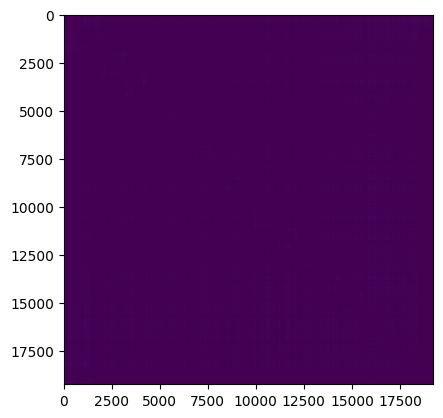

In [26]:
plt.imshow(A)

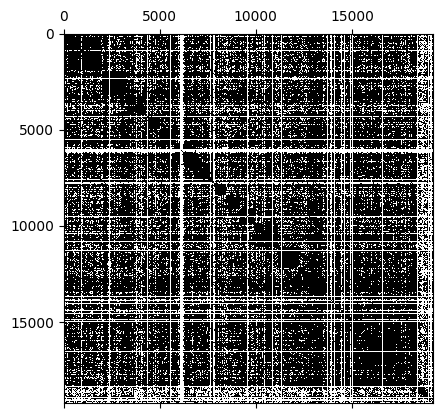

In [35]:
plt.spy(Anorm)

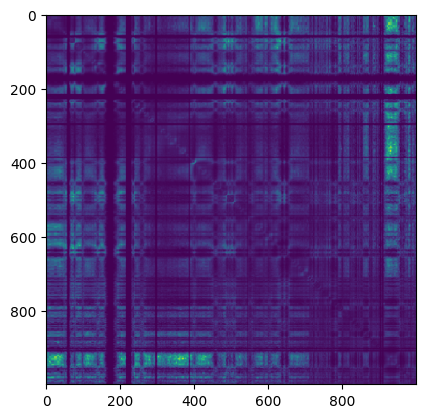

In [34]:
n = 1000
plt.imshow(Anorm[0:n, 0:n])

In [37]:
def cluster(X, knn=11, resolution=1.0):
    """A function to cluster a data matrix """
    # transform to adjacency graph 
    nbrs = NearestNeighbors(n_neighbors=knn, algorithm='ball_tree').fit(X)
    g = nbrs.kneighbors_graph(X).toarray()
    g = sc._utils.get_igraph_from_adjacency(g, directed=False)
    
    partition_type = leidenalg.RBConfigurationVertexPartition
    part = leidenalg.find_partition(g, partition_type)
    groups = np.array(part.membership)

    return groups

In [78]:
n = 5000
npca = 10
resolution = 0.02
n_neighbors = 100
min_dist = 0.8

gene_names = object_file['gene indices'][0:n]
X = Anorm[0:n, :]
pca = PCA(n_components=npca, svd_solver='arpack')
X = pca.fit_transform(X)
print(f"{X.shape=}")
clusters = cluster(X, resolution=resolution)
print(set(clusters))

"""UMAP embedding for plotting """
mappy = umap.UMAP(n_components=2, 
                  n_neighbors=n_neighbors,
                  min_dist=min_dist)

edf = mappy.fit_transform(X)
edf = pd.DataFrame(edf, columns=['UMAP 1', 'UMAP 2'])
edf['cluster'] = clusters
edf['gene_name'] = gene_names
edf = edf.reset_index(drop=False)
edf.head()

X.shape=(5000, 10)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43}


,index,UMAP 1,UMAP 2,cluster,gene_name
0,0,12.115832,10.760346,11,OR4F5
1,1,0.544264,-5.038157,19,OR4F29
2,2,0.723977,3.215356,26,OR4F16
3,3,8.710598,-7.206205,37,SAMD11
4,4,8.654583,-7.384233,37,NOC2L


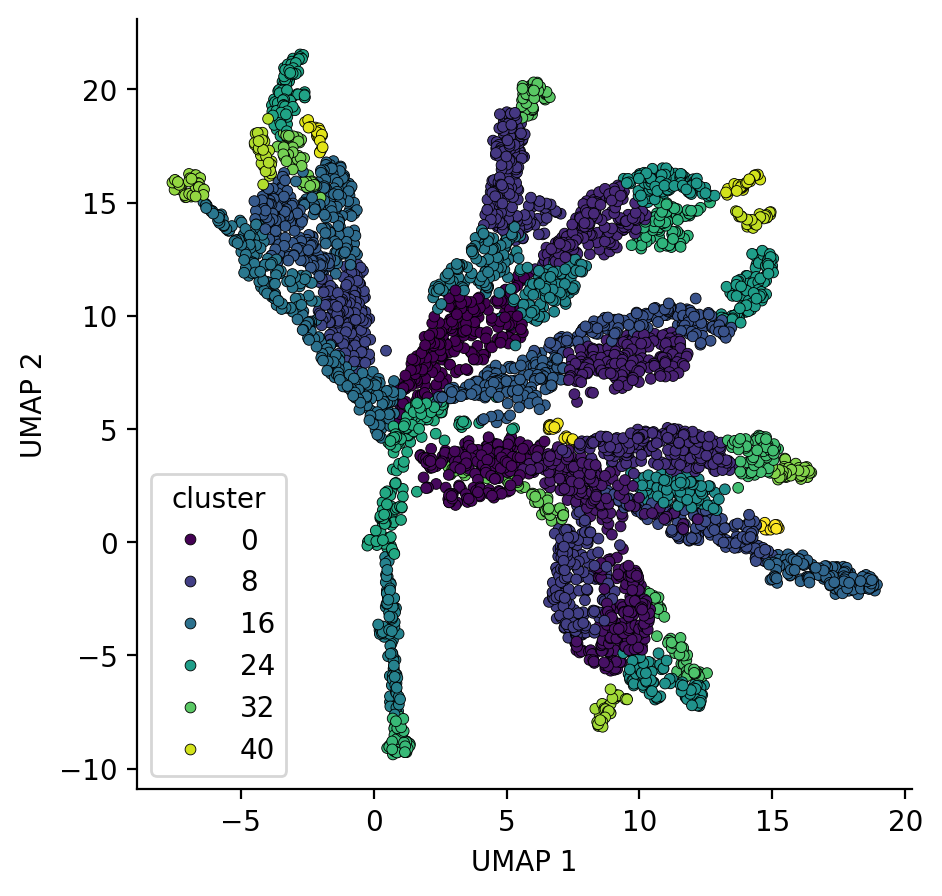

In [79]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(data=edf,
                x='UMAP 1',
                y='UMAP 2',
                hue='cluster',
                ec='k',
                s=15, 
                palette='viridis')

sns.despine()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(data=edf,
                x='UMAP 1',
                y='UMAP 2',
                hue='cluster',
                ec='k',
                s=15, 
                palette='viridis')

sns.despine()